<a href="https://colab.research.google.com/github/Srijha09/Making-Images-Artsy-Neural-Style-Transfer/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neural style transfer is an optimization technique used to take three images, a content image, a style reference image (such as an artwork by a famous painter), and the input image you want to style — and blend them together such that the input image is transformed to look like the content image, but “painted” in the style of the style image.

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

 we need to choose which device to run the network on and import the content and style images. Running the neural transfer algorithm on large images takes longer and will go much faster when running on a GPU

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
# Use smaller image size if gpu isn't available
if torch.cuda.is_available():
    imsize = (512, 512) 
else:
    imsize = (256, 256)  

# Resize image and transform to torch tensor
tfms = [
    transforms.Resize(imsize),
    transforms.ToTensor()
]
loader = transforms.Compose(tfms)

#convert into torch tensor
def image_loader(img_path):
    img = Image.open(img_path)
    # Insert 1 in shape of the tensor at axis 0 (batch size)
    # Extra dimension is required to fit the network's input dimensions
    if img_path[-3:].lower() == 'png':
        img = img.convert('RGB')
    img = loader(img).unsqueeze(0)
    
    return img.to(device, torch.float)


content_img = image_loader("/content/drive/My Drive/Neural Style Transfer/images/srija.jpg")
style_img = image_loader("/content/drive/My Drive/Neural Style Transfer/images/butterfly.png")

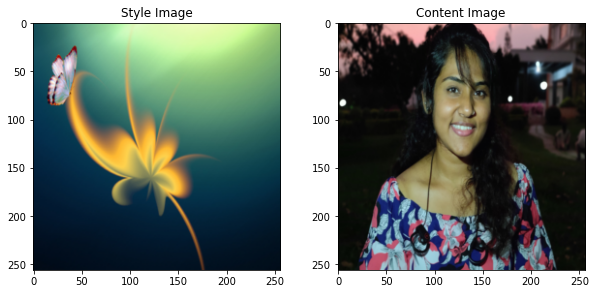

In [20]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    # Clone the tensor so it's not changed in-place
    image = tensor.cpu().clone()
    # Removed the extra dimension added previously
    image = image.squeeze(0)      
    image = unloader(image)
    # Now we have a normal image, let's display it
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure(figsize=(10,10))

plt.subplot(221)
imshow(style_img, title='Style Image')

plt.subplot(222)
imshow(content_img, title='Content Image')

In [21]:

class ContentLoss(nn.Module):
    
    def __init__(self, target):
        # Sub-class this class
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [22]:
def gram_matrix(input):
    # a is batch size, equal to 1
    # b is the number of feature maps
    # (c,d) are dimensions of feature map
    a, b, c, d = input.size()  

    # resize matrix to [b,(c*d)] form
    features = input.view(a * b, c * d)  
    
    # Compute the Gram-Matrix and normalize it
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

In [23]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        # Sub-class this class
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


In [24]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [25]:
vgg_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
vgg_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        # Sub-class this class
        super(Normalization, self).__init__()
        
        # Use .view to change the shape of the mean and std
        # tensors. They take the form [num_channels x 1 x 1] 
        # and become compatible with the image tensors
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize the image with VGG stats
        return (img - self.mean) / self.std

In [26]:
# Calculate content loss at conv level 4
content_layers_default = ['conv_4']

# Calculate style loss at each level
style_layers_default = [
    'conv_1', 
    'conv_2', 
    'conv_3', 
    'conv_4', 
    'conv_5'
]

def get_style_model_and_losses(cnn, 
                               normalization_mean, 
                               normalization_std,
                               style_img, 
                               content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default
                              ):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            # If we see a conv layer, increment i
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            # Replace in-place version with out-of-place as it
            # doesn't work too well with style/content losses
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

    # We then trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        # As soon as we encounter the last style/content layer, break the loop                       
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    
    # Grab the model until the cut-off point                           
    model = model[:(i + 1)]

    return model, style_losses, content_losses

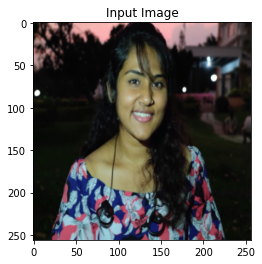

In [27]:
input_img = content_img.clone()
# For white noise, uncomment the line below
# input_img = torch.randn(content_img.data.size(), device=device)

# Display the input image
plt.figure()
imshow(input_img, title='Input Image')


In [28]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [29]:
def run_style_transfer(
    cnn, 
    normalization_mean, 
    normalization_std,
    content_img,
    style_img,
    input_img,
    num_steps=300,
    style_weight=1000000,
    content_weight=1):
    
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing...')
    print()
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # Clamp the image tensor to (0,1) range
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            
            style_score = 0
            content_score = 0
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f'Run {run[0]}:')
                print(f'Style Loss : {style_score.item():4f}')
                print(f'Content Loss: {content_score.item():4f}')
                print()
                plt.figure()
                imshow(input_img)
                plt.show()

            return style_score + content_score

        optimizer.step(closure)

    # Clamp the data one last time
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing...

Run 50:
Style Loss : 124.541679
Content Loss: 19.104153



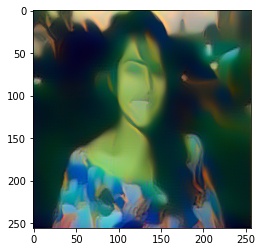

Run 100:
Style Loss : 40.112434
Content Loss: 19.932009



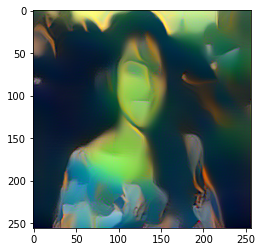

Run 150:
Style Loss : 22.042171
Content Loss: 19.730438



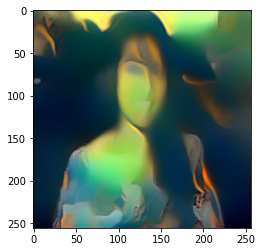

Run 200:
Style Loss : 13.903155
Content Loss: 19.595842



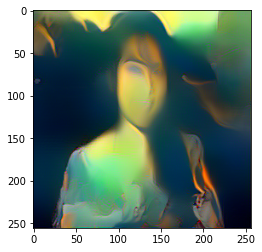

Run 250:
Style Loss : 9.651334
Content Loss: 19.387083



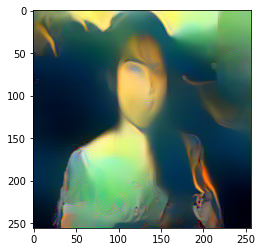

Run 300:
Style Loss : 8.603989
Content Loss: 18.989502



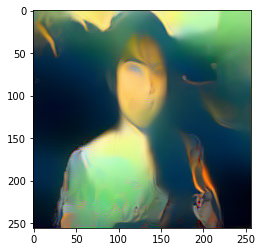

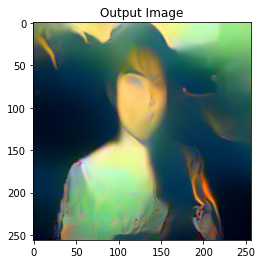

In [30]:
output = run_style_transfer(
    cnn,
    vgg_mean,
    vgg_std,
    content_img,
    style_img,
    input_img
)

plt.figure()
imshow(output, title='Output Image')

plt.show()